# Model Exploration
* This notebook is broken into two sections; Pre-Campaign Modeling and Post-Campaign modeling.
* The first section trains models using pre-campaign features of the dataset (demographic data) and then uses the whole dataset to try and predict which customers are likely to subscribe to a term deposit product so as to save call time for call center employees 
* The second section looks at the dataset as a whole to minimize the call time even more as well as looking at the customers that call center employees should prioritize and what ulitmately makes those customers subscribe.

In [9]:
import pandas as pd
import pycaret
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings(action='ignore')

In [37]:
df_ = pd.read_csv('Data/model-ready-term-deposit-marketing-2020.csv')
df_.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,y,duration_in_minutes
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,0,4.350000
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,0,2.516667
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,0,1.266667
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,0,1.533333
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,0,3.300000


In [39]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  40000 non-null  int64  
 1   job                  40000 non-null  object 
 2   marital              40000 non-null  object 
 3   education            40000 non-null  object 
 4   default              40000 non-null  int64  
 5   balance              40000 non-null  int64  
 6   housing              40000 non-null  int64  
 7   loan                 40000 non-null  int64  
 8   contact              40000 non-null  object 
 9   day                  40000 non-null  int64  
 10  month                40000 non-null  object 
 11  campaign             40000 non-null  int64  
 12  y                    40000 non-null  int64  
 13  duration_in_minutes  40000 non-null  float64
dtypes: float64(1), int64(8), object(5)
memory usage: 4.3+ MB


In [40]:
for col in df_.columns:
    if df_[col].dtype == 'object':
        df_[col] = df_[col].astype('category')

In [41]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  40000 non-null  int64   
 1   job                  40000 non-null  category
 2   marital              40000 non-null  category
 3   education            40000 non-null  category
 4   default              40000 non-null  int64   
 5   balance              40000 non-null  int64   
 6   housing              40000 non-null  int64   
 7   loan                 40000 non-null  int64   
 8   contact              40000 non-null  category
 9   day                  40000 non-null  int64   
 10  month                40000 non-null  category
 11  campaign             40000 non-null  int64   
 12  y                    40000 non-null  int64   
 13  duration_in_minutes  40000 non-null  float64 
dtypes: category(5), float64(1), int64(8)
memory usage: 2.9 MB


In [42]:
target_variable = df_['y']

X = df_.drop(columns='y', axis=1)

X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,duration_in_minutes
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,4.350000
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,2.516667
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,1.266667
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,1.533333
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,3.300000


## Pre-Campaign Modeling
* Looking at the first 8 columns of features this section looks at obtaining the highest recall score for class 1
* Pycaret will be used to look for optimal models to look at more closely
* RandomizedSearch and Optuna will be used for hyperparameter tuning
* For reproducability purposes, use seed=3046

In [43]:
pre_campaign_df = X.iloc[:, 0:8]
pre_campaign_df.head()

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,0,2143,1,0
1,44,technician,single,secondary,0,29,1,0
2,33,entrepreneur,married,secondary,0,2,1,1
3,47,blue-collar,married,unknown,0,1506,1,0
4,33,unknown,single,unknown,0,1,0,0


In [44]:
num_features = [col for col in pre_campaign_df.columns if X[col].dtype != 'category']
print(f"Numerical features:   {num_features}")
categ_features = [col for col in pre_campaign_df.columns if X[col].dtype == 'category']
print(f"Categorical features: {categ_features}")

Numerical features:   ['age', 'default', 'balance', 'housing', 'loan']
Categorical features: ['job', 'marital', 'education']


In [45]:
seed = 3046

In [46]:
from pycaret.classification import *
import random

# seed = random.randint(1000, 9999)

imbalance_methods = ['randomoversampler', 'smotetomek', 'smoteenn']
n_select = 5
imbalance_type_dict = {}


for type in imbalance_methods:
  print(f'Type of imbalance technique: {type}')
  s = setup(data=pre_campaign_df,
        target=target_variable, 
        session_id=seed, 
        train_size=.80, 
        fix_imbalance=True, 
        fix_imbalance_method=type,
        categorical_features=categ_features
      )
  # print(s.X_train)
  print()
  best_models = compare_models(sort='Recall', n_select=n_select)
  results = pull()
  # print(best_models)

  model_recall_score_dict = {}

  for i in range(n_select):
      model_recall_score_dict[results.index[i]] = results.iloc[i].Recall

  imbalance_type_dict[type] = model_recall_score_dict

  print(f"Imbalance type dictionary:\n{imbalance_type_dict}")

  # evaluation = [evaluate_model(estimator=model) for model in best_models]
  print('*'*60)


Type of imbalance technique: randomoversampler


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 9)"
4,Transformed data shape,"(67366, 25)"
5,Transformed train set shape,"(59366, 25)"
6,Transformed test set shape,"(8000, 25)"
7,Numeric features,5
8,Categorical features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.4641,0.5341,0.6028,0.0754,0.1245,0.0085,0.0320,0.2020
lr,Logistic Regression,0.5923,0.6033,0.5615,0.0976,0.1663,0.0489,0.0821,1.4480
ridge,Ridge Classifier,0.5930,0.6031,0.5615,0.0977,0.1665,0.0492,0.0825,0.0760
lda,Linear Discriminant Analysis,0.5930,0.6031,0.5615,0.0977,0.1665,0.0492,0.0825,0.0810
nb,Naive Bayes,0.5807,0.5924,0.5528,0.0937,0.1603,0.0416,0.0711,0.0620
ada,Ada Boost Classifier,0.6196,0.6140,0.5261,0.0992,0.1669,0.0513,0.0816,0.2770
gbc,Gradient Boosting Classifier,0.6504,0.6144,0.4894,0.1019,0.1687,0.0554,0.0830,0.7680
qda,Quadratic Discriminant Analysis,0.5704,0.5211,0.4564,0.0787,0.1274,0.0113,0.0197,0.0660
lightgbm,Light Gradient Boosting Machine,0.6989,0.6091,0.4346,0.1078,0.1726,0.0641,0.0878,0.3760
knn,K Neighbors Classifier,0.7965,0.5405,0.2304,0.1017,0.1411,0.0451,0.0499,0.3230


Imbalance type dictionary:
{'randomoversampler': {'svm': 0.6028, 'lr': 0.5615, 'ridge': 0.5615, 'lda': 0.5615, 'nb': 0.5528}}
************************************************************
Type of imbalance technique: smotetomek


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 9)"
4,Transformed data shape,"(65490, 25)"
5,Transformed train set shape,"(57490, 25)"
6,Transformed test set shape,"(8000, 25)"
7,Numeric features,5
8,Categorical features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.4720,0.5745,0.6348,0.0839,0.1482,0.0233,0.0491,2.0860
lr,Logistic Regression,0.5939,0.6030,0.5649,0.0984,0.1676,0.0505,0.0847,2.6700
ridge,Ridge Classifier,0.5930,0.6027,0.5623,0.0979,0.1667,0.0495,0.0829,2.0950
lda,Linear Discriminant Analysis,0.5930,0.6027,0.5623,0.0979,0.1667,0.0495,0.0829,2.1480
svm,SVM - Linear Kernel,0.5335,0.5080,0.4927,0.0727,0.1116,0.0027,0.0190,2.1880
knn,K Neighbors Classifier,0.6470,0.5340,0.3815,0.0823,0.1354,0.0185,0.0271,2.3330
dt,Decision Tree Classifier,0.8677,0.5372,0.1493,0.1325,0.1404,0.0690,0.0692,2.1140
et,Extra Trees Classifier,0.8927,0.5684,0.1010,0.1483,0.1200,0.0651,0.0665,2.7830
rf,Random Forest Classifier,0.9091,0.5786,0.0764,0.1866,0.1083,0.0693,0.0770,2.7390
qda,Quadratic Discriminant Analysis,0.9105,0.4933,0.0224,0.0511,0.0249,0.0003,-0.0030,2.0820


Imbalance type dictionary:
{'randomoversampler': {'svm': 0.6028, 'lr': 0.5615, 'ridge': 0.5615, 'lda': 0.5615, 'nb': 0.5528}, 'smotetomek': {'nb': 0.6348, 'lr': 0.5649, 'ridge': 0.5623, 'lda': 0.5623, 'svm': 0.4927}}
************************************************************
Type of imbalance technique: smoteenn


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 9)"
4,Transformed data shape,"(46900, 25)"
5,Transformed train set shape,"(38900, 25)"
6,Transformed test set shape,"(8000, 25)"
7,Numeric features,5
8,Categorical features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.0724,0.5000,1.0000,0.0724,0.1350,0.0000,0.0000,2.0650
ridge,Ridge Classifier,0.2963,0.5989,0.8334,0.0802,0.1464,0.0165,0.0527,2.1460
lda,Linear Discriminant Analysis,0.3047,0.5989,0.8286,0.0808,0.1472,0.0175,0.0549,2.1280
lr,Logistic Regression,0.3051,0.5994,0.8278,0.0807,0.1471,0.0175,0.0547,2.7080
nb,Naive Bayes,0.4344,0.5700,0.6793,0.0831,0.1481,0.0219,0.0499,2.2170
svm,SVM - Linear Kernel,0.5178,0.5069,0.5021,0.0697,0.1119,-0.0022,0.0135,2.1780
knn,K Neighbors Classifier,0.5454,0.5280,0.4937,0.0788,0.1360,0.0127,0.0225,2.3630
dt,Decision Tree Classifier,0.8096,0.5452,0.2361,0.1124,0.1522,0.0600,0.0653,2.1610
et,Extra Trees Classifier,0.8618,0.5800,0.1562,0.1287,0.1411,0.0668,0.0671,2.5390
rf,Random Forest Classifier,0.8822,0.5913,0.1264,0.1442,0.1347,0.0718,0.0720,2.6010


Imbalance type dictionary:
{'randomoversampler': {'svm': 0.6028, 'lr': 0.5615, 'ridge': 0.5615, 'lda': 0.5615, 'nb': 0.5528}, 'smotetomek': {'nb': 0.6348, 'lr': 0.5649, 'ridge': 0.5623, 'lda': 0.5623, 'svm': 0.4927}, 'smoteenn': {'dummy': 1.0, 'ridge': 0.8334, 'lda': 0.8286, 'lr': 0.8278, 'nb': 0.6793}}
************************************************************


In [47]:
new_X = get_config('X') #### the new X to use when exploring models below
new_X.head()

,age,job,marital,education,default,balance,housing,loan
20685,44,management,married,secondary,0,781,1,0
39744,51,management,married,tertiary,0,994,0,0
25714,54,services,married,unknown,0,386,0,1
15848,26,admin,married,secondary,0,233,1,0
23373,54,management,divorced,tertiary,0,124,0,0


In [48]:
new_y = get_config('y') #### the new y to use when exploring models below
new_y

20685    0
39744    0
25714    0
15848    0
23373    0
        ..
39534    0
8858     0
28540    0
18981    0
23493    0
Name: y, Length: 40000, dtype: int8

                      svm      lr   ridge     lda      nb
randomoversampler  0.6028  0.5615  0.5615  0.5615  0.5528
smotetomek         0.4927  0.5649  0.5623  0.5623  0.6348
smoteenn              NaN  0.8278  0.8334  0.8286  0.6793


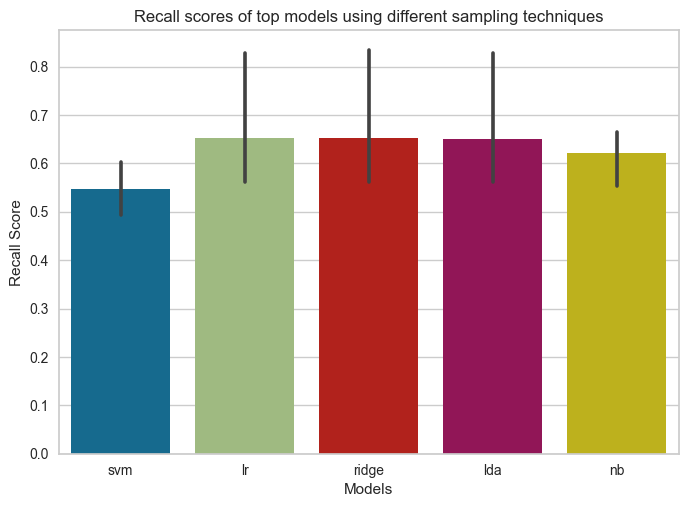

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data=imbalance_type_dict)
df = df.T.drop(columns='dummy', axis=1)
print(df)

sns.barplot(data=df)
plt.xlabel('Models')
plt.ylabel('Recall Score')
plt.title('Recall scores of top models using different sampling techniques')
plt.show()

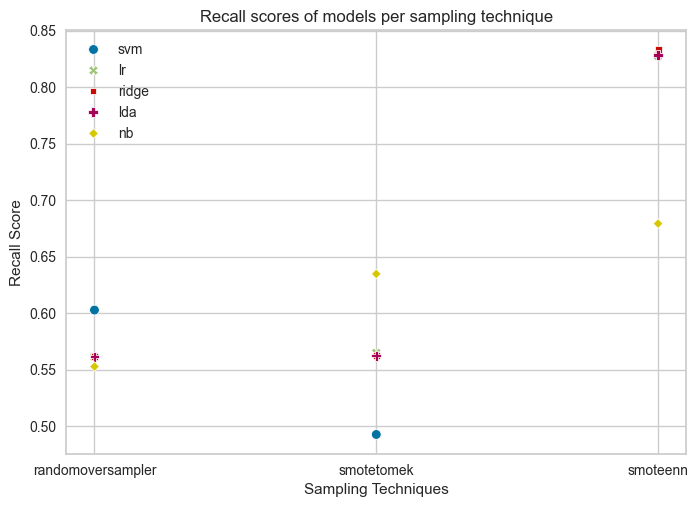

In [50]:
sns.scatterplot(df)
plt.xlabel('Sampling Techniques')
plt.ylabel('Recall Score')
plt.title('Recall scores of models per sampling technique')
plt.show()

Based on multiple tests to see what models and sampling techniques worked best, the results show a smoteenn technique working better for recall scores and the models that performed the best with smoteenn will be used along with svm.

### Model Experimentation
* This section will look at different models to explore as well as look at replicating some of the scores from above with the different sampling techniques

In [51]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.combine import SMOTETomek, SMOTEENN

ros = RandomOverSampler(random_state=seed)
smotenc = SMOTENC(categorical_features=categ_features, sampling_strategy='all', random_state=seed)
smoteenn = SMOTEENN(random_state=seed)

dummy_df = pd.get_dummies(new_X)

X_train, X_test, y_train, y_test = train_test_split(dummy_df,
                                                    new_y, 
                                                    train_size=.80, 
                                                    random_state=seed
                                                    )

X_train_resample, y_train_resample = smoteenn.fit_resample(X_train, y_train)

In [52]:
original_target_distribution = new_y.sum()/new_X.shape[0]
original_target_distribution

0.0724

In [53]:
y_train_resample.sum()/X_train_resample.shape[0]

0.6147586170687528

In [54]:
lr = LogisticRegression(random_state=seed)
lda = LinearDiscriminantAnalysis()
ridge = RidgeClassifier(random_state=seed)
gaussian_nb = GaussianNB()
sdg = SGDClassifier(random_state=seed)

models_dict = {
    'Logistic Regression': lr,
    'Linear Discrimination Analysis': lda,
    'Ridge Classifier': ridge,
    'Gaussian Naive-Bayes': gaussian_nb,
    'Stochastic Gradient Descent': sdg
    }


In [55]:
sampling_techniques = [ros, SMOTETomek(random_state=seed), smoteenn]

for tech in sampling_techniques:
    dummy_df = pd.get_dummies(new_X)

    X_train, X_test, y_train, y_test = train_test_split(dummy_df, new_y, train_size=.80, random_state=seed)

    X_train_resample, y_train_resample = tech.fit_resample(X_train, y_train)

    print(f"Sampling technique: {tech}")
    for name, model in models_dict.items():
        print(f"{'*'*40} Model: {name} {'*'*40}")
        model.fit(X_train_resample, y_train_resample)
        y_preds = model.predict(X_test)
        print(classification_report(y_test, y_preds))
        print(confusion_matrix(y_test, y_preds))

Sampling technique: RandomOverSampler(random_state=3046, sampling_strategy='auto', shrinkage=None)
**************************************** Model: Logistic Regression ****************************************
              precision    recall  f1-score   support

           0       0.95      0.60      0.73      7449
           1       0.09      0.56      0.16       551

    accuracy                           0.60      8000
   macro avg       0.52      0.58      0.45      8000
weighted avg       0.89      0.60      0.69      8000

[[4451 2998]
 [ 240  311]]
**************************************** Model: Linear Discrimination Analysis ****************************************
              precision    recall  f1-score   support

           0       0.95      0.60      0.74      7449
           1       0.09      0.56      0.16       551

    accuracy                           0.60      8000
   macro avg       0.52      0.58      0.45      8000
weighted avg       0.89      0.60      0.70   

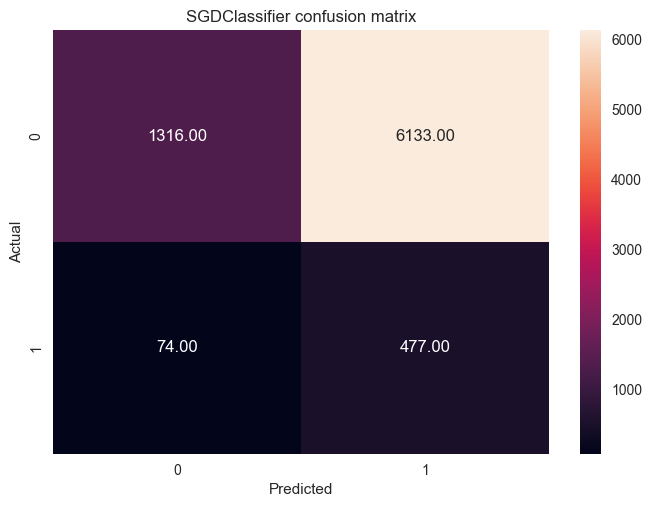

In [56]:
models_dict['Stochastic Gradient Descent'].fit(X_train_resample, y_train_resample)
pred = models_dict['Stochastic Gradient Descent'].predict(X_test)

sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt='.2f')
plt.title('SGDClassifier confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Hyperparameter Tuning
* SGDClassifier model will be tuned due to the fact that the amount of false negatives where considerably lower than the other models

In [58]:
import numpy as np
import optuna

n = X_train_resample.shape[0]
svm = models_dict['Stochastic Gradient Descent']

params = {
    'alpha': np.arange(.0000001, 1, 10),
    # 'max_iter': np.arange(1, 1000, 100)
    'max_iter': np.arange(200, 1000, 50)
}

random_grid_search = RandomizedSearchCV(estimator=svm,
                                        param_distributions=params,
                                        random_state=seed,
                                        cv=5,
                                        scoring='recall'
                                        )

random_grid_search.fit(X_train_resample, y_train_resample)

preds = random_grid_search.predict(X_test)
print(f"Best params: {random_grid_search.best_params_}")

Best params: {'max_iter': 700, 'alpha': 1e-07}


In [59]:
tuned_sgd = SGDClassifier(alpha=1e-07, max_iter=900)
tuned_sgd.fit(X_train_resample, y_train_resample)

preds = tuned_sgd.predict(X_test)

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.15      0.26      7449
           1       0.07      0.87      0.13       551

    accuracy                           0.20      8000
   macro avg       0.51      0.51      0.19      8000
weighted avg       0.88      0.20      0.25      8000

[[1108 6341]
 [  69  482]]


In [60]:
def objective(trial):
    svm_alpha = trial.suggest_float('svm_alpha', 1e-07, 1, log=True)
    svm_max_iter = trial.suggest_int('svm_max_iter', 200, 1000)
    regressor_obj = SGDClassifier(alpha=svm_alpha, max_iter=svm_max_iter)
    
    dummy_df = pd.get_dummies(new_X)
    
    X_train, X_test, y_train, y_test = train_test_split(dummy_df, new_y, train_size=.80, random_state=seed)

    X_train_resample, y_train_resample = smoteenn.fit_resample(X_train, y_train)

    regressor_obj.fit(X_train_resample, y_train_resample)
    preds = regressor_obj.predict(X_test)
    print(classification_report(y_test, preds))

study = optuna.create_study()
study.optimize(objective, n_trials=10)

[I 2025-09-18 08:04:43,696] A new study created in memory with name: no-name-399d6426-d588-4bcb-8515-1f7a49132274
[W 2025-09-18 08:06:33,986] Trial 0 failed with parameters: {'svm_alpha': 0.3542809010207111, 'svm_max_iter': 790} because of the following error: The value None could not be cast to float..
[W 2025-09-18 08:06:34,004] Trial 0 failed with value None.


              precision    recall  f1-score   support

           0       0.93      0.82      0.87      7449
           1       0.06      0.16      0.09       551

    accuracy                           0.77      8000
   macro avg       0.50      0.49      0.48      8000
weighted avg       0.87      0.77      0.82      8000



[W 2025-09-18 08:07:25,454] Trial 1 failed with parameters: {'svm_alpha': 0.04189988820332539, 'svm_max_iter': 490} because of the following error: The value None could not be cast to float..
[W 2025-09-18 08:07:25,459] Trial 1 failed with value None.


              precision    recall  f1-score   support

           0       0.94      0.20      0.33      7449
           1       0.07      0.83      0.13       551

    accuracy                           0.25      8000
   macro avg       0.51      0.52      0.23      8000
weighted avg       0.88      0.25      0.32      8000



[W 2025-09-18 08:08:12,103] Trial 2 failed with parameters: {'svm_alpha': 0.12201007150234658, 'svm_max_iter': 503} because of the following error: The value None could not be cast to float..
[W 2025-09-18 08:08:12,106] Trial 2 failed with value None.


              precision    recall  f1-score   support

           0       0.94      0.21      0.34      7449
           1       0.07      0.83      0.13       551

    accuracy                           0.25      8000
   macro avg       0.51      0.52      0.24      8000
weighted avg       0.88      0.25      0.33      8000



[W 2025-09-18 08:08:57,089] Trial 3 failed with parameters: {'svm_alpha': 2.9756895936313384e-07, 'svm_max_iter': 886} because of the following error: The value None could not be cast to float..
[W 2025-09-18 08:08:57,094] Trial 3 failed with value None.


              precision    recall  f1-score   support

           0       0.93      0.71      0.81      7449
           1       0.08      0.32      0.12       551

    accuracy                           0.68      8000
   macro avg       0.51      0.52      0.47      8000
weighted avg       0.88      0.68      0.76      8000



[W 2025-09-18 08:09:41,838] Trial 4 failed with parameters: {'svm_alpha': 0.401646472487424, 'svm_max_iter': 214} because of the following error: The value None could not be cast to float..
[W 2025-09-18 08:09:41,840] Trial 4 failed with value None.


              precision    recall  f1-score   support

           0       0.92      0.39      0.55      7449
           1       0.06      0.56      0.11       551

    accuracy                           0.40      8000
   macro avg       0.49      0.47      0.33      8000
weighted avg       0.86      0.40      0.52      8000



[W 2025-09-18 08:10:27,765] Trial 5 failed with parameters: {'svm_alpha': 2.8809176085591654e-07, 'svm_max_iter': 394} because of the following error: The value None could not be cast to float..
[W 2025-09-18 08:10:27,770] Trial 5 failed with value None.


              precision    recall  f1-score   support

           0       0.94      0.41      0.57      7449
           1       0.08      0.67      0.14       551

    accuracy                           0.43      8000
   macro avg       0.51      0.54      0.35      8000
weighted avg       0.88      0.43      0.54      8000



[W 2025-09-18 08:11:14,268] Trial 6 failed with parameters: {'svm_alpha': 2.8421897819409123e-06, 'svm_max_iter': 287} because of the following error: The value None could not be cast to float..
[W 2025-09-18 08:11:14,287] Trial 6 failed with value None.


              precision    recall  f1-score   support

           0       0.93      0.89      0.91      7449
           1       0.06      0.10      0.08       551

    accuracy                           0.83      8000
   macro avg       0.50      0.50      0.49      8000
weighted avg       0.87      0.83      0.85      8000



[W 2025-09-18 08:12:00,368] Trial 7 failed with parameters: {'svm_alpha': 0.13844631281298903, 'svm_max_iter': 640} because of the following error: The value None could not be cast to float..
[W 2025-09-18 08:12:00,371] Trial 7 failed with value None.


              precision    recall  f1-score   support

           0       0.93      0.88      0.90      7449
           1       0.06      0.11      0.08       551

    accuracy                           0.83      8000
   macro avg       0.50      0.49      0.49      8000
weighted avg       0.87      0.83      0.85      8000



[W 2025-09-18 08:12:44,255] Trial 8 failed with parameters: {'svm_alpha': 0.013035703183274162, 'svm_max_iter': 429} because of the following error: The value None could not be cast to float..
[W 2025-09-18 08:12:44,258] Trial 8 failed with value None.


              precision    recall  f1-score   support

           0       0.93      0.89      0.91      7449
           1       0.06      0.09      0.07       551

    accuracy                           0.84      8000
   macro avg       0.50      0.49      0.49      8000
weighted avg       0.87      0.84      0.85      8000



[W 2025-09-18 08:13:29,542] Trial 9 failed with parameters: {'svm_alpha': 0.8345637981542878, 'svm_max_iter': 360} because of the following error: The value None could not be cast to float..
[W 2025-09-18 08:13:29,550] Trial 9 failed with value None.


              precision    recall  f1-score   support

           0       0.93      0.76      0.84      7449
           1       0.06      0.21      0.10       551

    accuracy                           0.72      8000
   macro avg       0.50      0.49      0.47      8000
weighted avg       0.87      0.72      0.78      8000



In [61]:
sdg = SGDClassifier(alpha=0.004591268532654977, max_iter=540, random_state=seed)

sdg.fit(X_train_resample, y_train_resample)
preds = sdg.predict(X_test)

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.17      0.29      7449
           1       0.07      0.87      0.13       551

    accuracy                           0.22      8000
   macro avg       0.51      0.52      0.21      8000
weighted avg       0.89      0.22      0.28      8000

[[1282 6167]
 [  70  481]]


              precision    recall  f1-score   support

           0       0.99      0.46      0.63      7416
           1       0.12      0.92      0.21       584

    accuracy                           0.49      8000
   macro avg       0.55      0.69      0.42      8000
weighted avg       0.92      0.49      0.60      8000



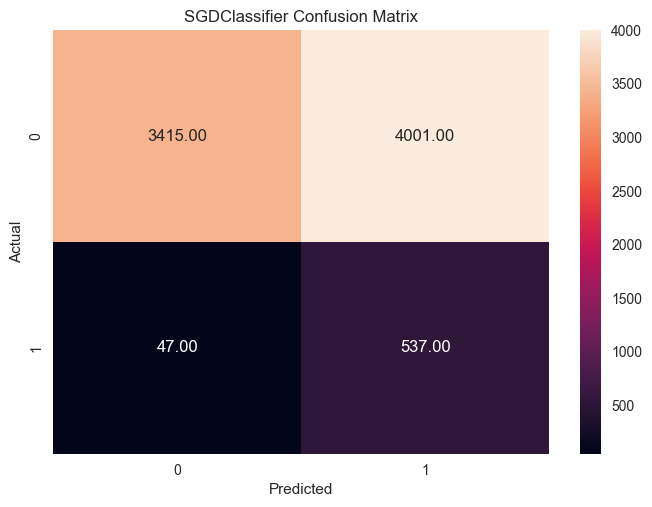

In [62]:
## using the trained, RandomizedSearch SGD model from above this now trains on the whole dataset to see how well it predicts customers who will subscribe

X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X), target_variable, train_size=.80, random_state=seed)
X_train_resample, y_train_resample = smoteenn.fit_resample(X_train, y_train)

tuned_sgd.fit(X_train_resample, y_train_resample)
preds = tuned_sgd.predict(X_test)
print(classification_report(y_test, preds))
sns.heatmap(data=confusion_matrix(y_test, preds), fmt='.2f', annot=True)
plt.title('SGDClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Using the trained SGD model on the whole dataset using SMOTEenn for the sampling technique we can see that a recall score of ~91% is achieved. Meaning, this model is correctly classifying over 90% of the customers in the dataset who ACTUALLY subscribed to the term deposit product, thus saving roughly 173 hours of call time (number of true negatives * median call time of 3 minutes)/60.

## Post-Campaign Modeling
* The second section of this notebook looks to take the whole dataset and see how much additional call time can be reduced as well as looking at what makes a customer subscribe to the product using unsupervised learning techniques.
* Using Pycaret, we will see which models perform well with the entire dataset looking at different metrics such as precision, recall, and f1_macro.
* For reproducability purposes, use seed=3121

In [63]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,duration_in_minutes
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,4.350000
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,2.516667
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,1.266667
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,1.533333
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,3.300000


In [65]:
full_dataset_categorical_features = [col for col in X.columns if X[col].dtype == 'category']
print(f"Categorical categories:\n{full_dataset_categorical_features}")

Categorical categories:
['job', 'marital', 'education', 'contact', 'month']


In [66]:
seed = 3121

In [67]:
# seed = random.randint(1000, 9999)

imbalance_type_dict_layer_2 = {}

for type in imbalance_methods:
  print(f'Type of imbalance technique: {type}')
  s = setup(data=X,
        target=target_variable, 
        session_id=seed, 
        train_size=.80, 
        fix_imbalance=True, 
        fix_imbalance_method=type,
        categorical_features=full_dataset_categorical_features
      )
  # print(s.X_train)
  print()
  best_models = compare_models(sort='Precision', n_select=n_select)
  results = pull()
  # print(best_models)

  model_precision_score_dict = {}

  for i in range(n_select):
      model_precision_score_dict[results.index[i]] = results.iloc[i]['Prec.']

  imbalance_type_dict_layer_2[type] = model_precision_score_dict

  print(imbalance_type_dict_layer_2)

  # evaluation = [evaluate_model(estimator=model) for model in best_models]
  print('-'*50)

Type of imbalance technique: randomoversampler


,Description,Value
0,Session id,3121
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 14)"
4,Transformed data shape,"(67366, 42)"
5,Transformed train set shape,"(59366, 42)"
6,Transformed test set shape,"(8000, 42)"
7,Numeric features,8
8,Categorical features,5
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9317,0.9220,0.2214,0.5765,0.3188,0.2903,0.3281,0.8090
rf,Random Forest Classifier,0.9343,0.9432,0.4199,0.5619,0.4802,0.4460,0.4516,0.7540
dt,Decision Tree Classifier,0.9190,0.6919,0.4264,0.4397,0.4325,0.3889,0.3892,0.1350
lightgbm,Light Gradient Boosting Machine,0.8903,0.9499,0.8874,0.3880,0.5398,0.4882,0.5424,0.4270
ridge,Ridge Classifier,0.8777,0.9262,0.8278,0.3534,0.4952,0.4382,0.4899,0.0780
lda,Linear Discriminant Analysis,0.8777,0.9262,0.8274,0.3533,0.4950,0.4380,0.4897,0.1830
gbc,Gradient Boosting Classifier,0.8724,0.9438,0.8917,0.3509,0.5034,0.4458,0.5101,1.3940
ada,Ada Boost Classifier,0.8685,0.9295,0.8507,0.3385,0.4841,0.4245,0.4841,0.4530
lr,Logistic Regression,0.8657,0.9297,0.8623,0.3347,0.4821,0.4217,0.4845,1.4800
nb,Naive Bayes,0.8309,0.8419,0.6841,0.2533,0.3696,0.2951,0.3440,0.0840


{'randomoversampler': {'et': 0.5765, 'rf': 0.5619, 'dt': 0.4397, 'lightgbm': 0.388, 'ridge': 0.3534}}
--------------------------------------------------
Type of imbalance technique: smotetomek


,Description,Value
0,Session id,3121
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 14)"
4,Transformed data shape,"(66800, 42)"
5,Transformed train set shape,"(58800, 42)"
6,Transformed test set shape,"(8000, 42)"
7,Numeric features,8
8,Categorical features,5
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9388,0.9513,0.4774,0.5977,0.5303,0.4980,0.5019,3.2650
rf,Random Forest Classifier,0.9330,0.9409,0.3250,0.5656,0.4123,0.3796,0.3963,3.9210
et,Extra Trees Classifier,0.9318,0.9301,0.3129,0.5529,0.3989,0.3658,0.3829,3.6380
gbc,Gradient Boosting Classifier,0.9323,0.9415,0.5106,0.5351,0.5219,0.4855,0.4860,5.8590
ada,Ada Boost Classifier,0.9215,0.9207,0.4441,0.4580,0.4500,0.4078,0.4084,3.6800
dt,Decision Tree Classifier,0.9159,0.7098,0.4687,0.4265,0.4463,0.4010,0.4017,2.7760
ridge,Ridge Classifier,0.8806,0.9287,0.8269,0.3594,0.5009,0.4449,0.4950,2.8610
lda,Linear Discriminant Analysis,0.8805,0.9287,0.8269,0.3593,0.5008,0.4447,0.4949,2.8190
lr,Logistic Regression,0.8715,0.9297,0.8468,0.3436,0.4887,0.4300,0.4876,3.4630
svm,SVM - Linear Kernel,0.7347,0.7988,0.7429,0.2087,0.3100,0.2229,0.2928,2.9140


{'randomoversampler': {'et': 0.5765, 'rf': 0.5619, 'dt': 0.4397, 'lightgbm': 0.388, 'ridge': 0.3534}, 'smotetomek': {'lightgbm': 0.5977, 'rf': 0.5656, 'et': 0.5529, 'gbc': 0.5351, 'ada': 0.458}}
--------------------------------------------------
Type of imbalance technique: smoteenn


,Description,Value
0,Session id,3121
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 14)"
4,Transformed data shape,"(58311, 42)"
5,Transformed train set shape,"(50311, 42)"
6,Transformed test set shape,"(8000, 42)"
7,Numeric features,8
8,Categorical features,5
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9270,0.9366,0.5663,0.4963,0.5288,0.4894,0.4908,3.5740
lightgbm,Light Gradient Boosting Machine,0.9252,0.9484,0.7156,0.4887,0.5805,0.5410,0.5530,3.7640
rf,Random Forest Classifier,0.9224,0.9412,0.6461,0.4742,0.5467,0.5054,0.5128,3.5460
gbc,Gradient Boosting Classifier,0.9122,0.9400,0.7216,0.4366,0.5438,0.4985,0.5180,5.3460
ada,Ada Boost Classifier,0.9093,0.9230,0.6595,0.4198,0.5128,0.4655,0.4801,3.3620
dt,Decision Tree Classifier,0.9057,0.7920,0.6591,0.4071,0.5029,0.4540,0.4704,2.8310
lda,Linear Discriminant Analysis,0.8576,0.9289,0.8744,0.3224,0.4710,0.4084,0.4767,2.7400
ridge,Ridge Classifier,0.8575,0.9289,0.8744,0.3222,0.4707,0.4081,0.4765,2.7900
lr,Logistic Regression,0.8453,0.9295,0.8839,0.3051,0.4534,0.3874,0.4623,3.5040
nb,Naive Bayes,0.7454,0.8531,0.8300,0.1989,0.3209,0.2310,0.3211,2.7510


{'randomoversampler': {'et': 0.5765, 'rf': 0.5619, 'dt': 0.4397, 'lightgbm': 0.388, 'ridge': 0.3534}, 'smotetomek': {'lightgbm': 0.5977, 'rf': 0.5656, 'et': 0.5529, 'gbc': 0.5351, 'ada': 0.458}, 'smoteenn': {'et': 0.4963, 'lightgbm': 0.4887, 'rf': 0.4742, 'gbc': 0.4366, 'ada': 0.4198}}
--------------------------------------------------


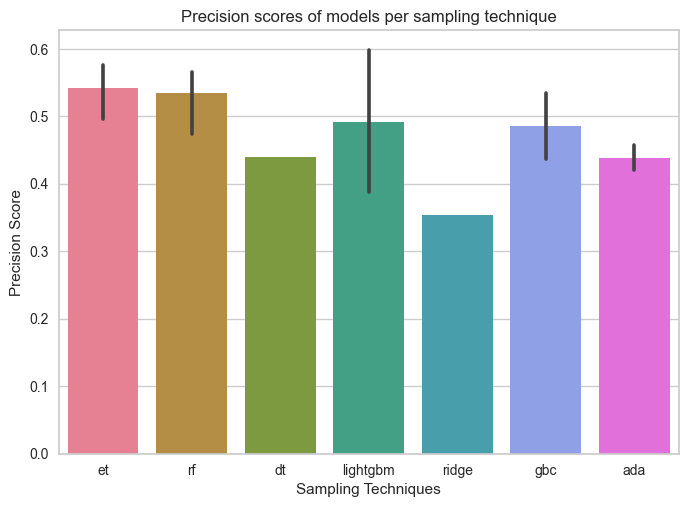

In [68]:
df = pd.DataFrame(imbalance_type_dict_layer_2)
df = df.T

sns.barplot(df)
plt.xlabel('Sampling Techniques')
plt.ylabel('Precision Score')
plt.title('Precision scores of models per sampling technique')
plt.show()

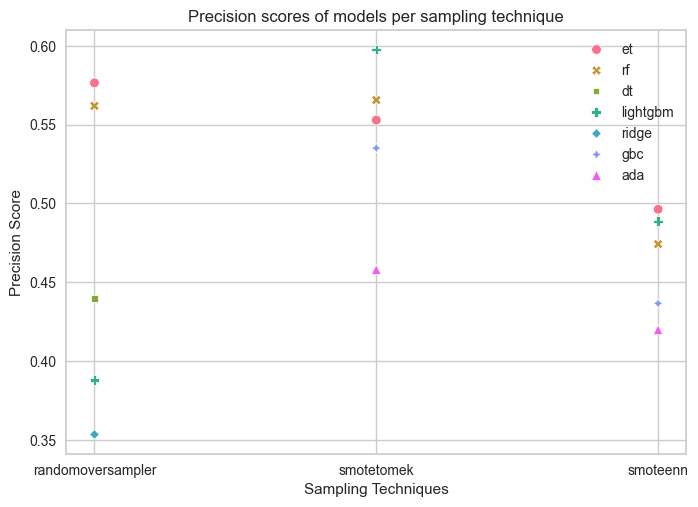

In [69]:
sns.scatterplot(df)
plt.xlabel('Sampling Techniques')
plt.ylabel('Precision Score')
plt.title('Precision scores of models per sampling technique')
plt.show()

Using Pycaret to see what models work with different sampling techniques the results look to be that multiple tree based models work the best with SmoteTomek as the sampling technique. Below, the ExtraTreeClassifier will be used with a randomoversampling technique and a LightGBM model will be used with SmoteTomek.

In [71]:
from imblearn.over_sampling import RandomOverSampler

dummy_new_X = pd.get_dummies(data=s.X)

X_train, X_test, y_train, y_test = train_test_split(dummy_new_X, s.y, train_size=.80, random_state=seed)
X_train_resampled_tomek, y_train_resampled_tomek = SMOTETomek(random_state=seed).fit_resample(X_train, y_train)
X_train_resampled_random, y_train_resampled_random = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)


In [72]:
from sklearn.tree import ExtraTreeClassifier
from lightgbm import LGBMClassifier

second_layer_models = {
    'extra_tree': ExtraTreeClassifier(random_state=seed),
    'lightgbm': LGBMClassifier(random_state=seed)
}

for name, model in second_layer_models.items():
    print(f"{'*'*40} Model: {name} {'*'*40}")
    if name == 'extra_tree':
        extra_tree = model
        extra_tree.fit(X_train_resampled_random, y_train_resampled_random)
        preds = extra_tree.predict(X_test)
        print(classification_report(y_test, preds))
        print(confusion_matrix(y_test, preds))
    else:
        lgbm = model
        lgbm.fit(X_train_resampled_tomek, y_train_resampled_tomek)
        preds = lgbm.predict(X_test)
        print(classification_report(y_test, preds))
        print(confusion_matrix(y_test, preds))

**************************************** Model: extra_tree ****************************************
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7413
           1       0.36      0.36      0.36       587

    accuracy                           0.91      8000
   macro avg       0.66      0.65      0.65      8000
weighted avg       0.91      0.91      0.91      8000

[[7043  370]
 [ 378  209]]
**************************************** Model: lightgbm ****************************************
[LightGBM] [Info] Number of positive: 29395, number of negative: 29395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 58790, number of used features: 40
[LightGBM] [Info] [binary

In [74]:
from sklearn.metrics import f1_score

class_weights = np.linspace(0.0, .99, 30)

results_list = []
false_pos_list = []
false_neg_list = []
f1_list = []

for i in class_weights:
    model = LGBMClassifier(class_weight={0:i, 1:1.0-i})
    model.fit(X_train_resampled_tomek, y_train_resampled_tomek)
    preds=model.predict(X_test)
    conf_matrix=confusion_matrix(y_test, preds)
    fp=conf_matrix[0][1]
    fn=conf_matrix[1][0]

    results_list.append(results)
    false_pos_list.append(fp)
    false_neg_list.append(fn)
    print(f"Class 0 weight: {i} - Class 1 weight: {1.0-i}")
    print(classification_report(y_test, preds))
    print(conf_matrix)


# print(class_weights)
# print(false_pos_list)
# print(false_neg_list)

[LightGBM] [Info] Number of positive: 29395, number of negative: 29395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 58790, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

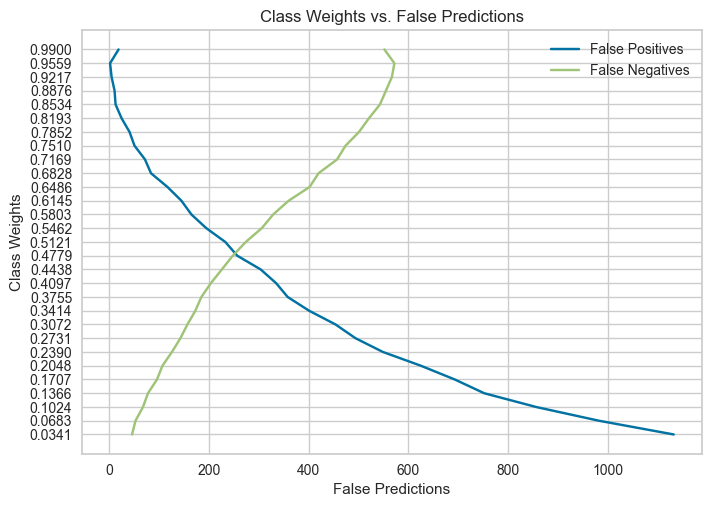

In [75]:
plt.plot(false_pos_list[1:], class_weights[1:])
plt.plot(false_neg_list[1:], class_weights[1:])
# plt.plot(f1_list, class_weights)
plt.yticks([i for i in class_weights[1:]])
plt.xlabel('False Predictions')
plt.ylabel('Class Weights')
plt.legend(('False Positives', 'False Negatives'))
plt.title('Class Weights vs. False Predictions')
plt.show()

In [76]:
params = {
    'max_depth': np.arange(1,8),
    'num_leaves': np.arange(2,100,10),
    'min_data_in_leaf': np.arange(100,10000,10),
    'num_iterations': np.arange(2,10),
    'class_weight': [{0:class_weights[14], 1:1-class_weights[14]}],
    'force_row_wise': [True],
    'verbose': [-1]
}

grid = RandomizedSearchCV(estimator=second_layer_models['lightgbm'], param_distributions=params, n_jobs=-1, random_state=seed, cv=5, scoring='precision')

grid.fit(X_train_resampled_tomek, y_train_resampled_tomek)
preds = grid.predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))
print(f"Best params: {grid.best_params_}")

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.32      0.80      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.83      0.69      8000
weighted avg       0.93      0.86      0.88      8000

[[6404 1009]
 [ 120  467]]
Best params: {'verbose': -1, 'num_leaves': 42, 'num_iterations': 9, 'min_data_in_leaf': 1340, 'max_depth': 7, 'force_row_wise': True, 'class_weight': {0: 0.47793103448275864, 1: 0.5220689655172414}}


In [77]:
def objective(trial):
    lgb_max_depth = trial.suggest_int('lgb_max_depth', 1, 8)
    lgb_num_leaves = trial.suggest_int('lgb_num_leaves', 2,100)
    lgb_min_data_in_leaf = trial.suggest_int('lgb_min_data_in_leaf',100,10000,log=True)
    lgb_num_iter = trial.suggest_int('lgb_num_iter', 2,10)

    regressor_obj = LGBMClassifier(max_depth=lgb_max_depth, num_leaves=lgb_num_leaves, min_data_in_leaf=lgb_min_data_in_leaf, num_iterations=lgb_num_iter, class_weight={0:class_weights[14], 1:1-class_weights[14]}, random_state=seed, force_row_wise=True, verbose=-1)
    
    dummy_df = pd.get_dummies(s.X)
    
    X_train, X_test, y_train, y_test = train_test_split(dummy_df, s.y, train_size=.80, random_state=seed)
    X_train_resample, y_train_resample = SMOTETomek(random_state=seed).fit_resample(X_train, y_train)

    regressor_obj.fit(X_train_resample, y_train_resample)
    preds = regressor_obj.predict(X_test)
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[I 2025-09-18 13:30:53,579] A new study created in memory with name: no-name-5675fb45-6031-48d1-b973-1775aebc163f


[W 2025-09-18 13:30:56,204] Trial 0 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 6, 'lgb_min_data_in_leaf': 4072, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:30:56,205] Trial 0 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2025-09-18 13:30:58,773] Trial 1 failed with parameters: {'lgb_max_depth': 2, 'lgb_num_leaves': 100, 'lgb_min_data_in_leaf': 774, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:30:58,774] Trial 1 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.77      0.87      7413
           1       0.23      0.85      0.36       587

    accuracy                           0.78      8000
   macro avg       0.61      0.81      0.61      8000
weighted avg       0.93      0.78      0.83      8000

[[5726 1687]
 [  86  501]]


[W 2025-09-18 13:31:01,223] Trial 2 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 12, 'lgb_min_data_in_leaf': 1208, 'lgb_num_iter': 9} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:01,224] Trial 2 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2025-09-18 13:31:03,649] Trial 3 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 11, 'lgb_min_data_in_leaf': 180, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:03,649] Trial 3 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7413
           1       0.32      0.84      0.46       587

    accuracy                           0.86      8000
   macro avg       0.65      0.85      0.69      8000
weighted avg       0.94      0.86      0.88      8000

[[6359 1054]
 [  93  494]]


[W 2025-09-18 13:31:06,467] Trial 4 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 82, 'lgb_min_data_in_leaf': 2519, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:06,468] Trial 4 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.75      0.85      7413
           1       0.21      0.87      0.34       587

    accuracy                           0.75      8000
   macro avg       0.60      0.81      0.60      8000
weighted avg       0.93      0.75      0.81      8000

[[5527 1886]
 [  78  509]]


[W 2025-09-18 13:31:09,023] Trial 5 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 71, 'lgb_min_data_in_leaf': 5994, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:09,024] Trial 5 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7413
           1       0.24      0.79      0.37       587

    accuracy                           0.80      8000
   macro avg       0.61      0.79      0.62      8000
weighted avg       0.93      0.80      0.84      8000

[[5937 1476]
 [ 124  463]]


[W 2025-09-18 13:31:11,584] Trial 6 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 52, 'lgb_min_data_in_leaf': 5702, 'lgb_num_iter': 10} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:11,584] Trial 6 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.81      0.88      7413
           1       0.24      0.75      0.36       587

    accuracy                           0.80      8000
   macro avg       0.61      0.78      0.62      8000
weighted avg       0.92      0.80      0.85      8000

[[5994 1419]
 [ 145  442]]


[W 2025-09-18 13:31:14,215] Trial 7 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 44, 'lgb_min_data_in_leaf': 200, 'lgb_num_iter': 10} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:14,216] Trial 7 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.81      0.88      7413
           1       0.24      0.75      0.36       587

    accuracy                           0.80      8000
   macro avg       0.61      0.78      0.62      8000
weighted avg       0.92      0.80      0.85      8000

[[5994 1419]
 [ 145  442]]


[W 2025-09-18 13:31:16,832] Trial 8 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 35, 'lgb_min_data_in_leaf': 119, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:16,833] Trial 8 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.81      0.88      7413
           1       0.24      0.75      0.36       587

    accuracy                           0.80      8000
   macro avg       0.61      0.78      0.62      8000
weighted avg       0.92      0.80      0.85      8000

[[5994 1419]
 [ 145  442]]


[W 2025-09-18 13:31:19,511] Trial 9 failed with parameters: {'lgb_max_depth': 7, 'lgb_num_leaves': 28, 'lgb_min_data_in_leaf': 1672, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:19,512] Trial 9 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.78      0.87      7413
           1       0.23      0.81      0.36       587

    accuracy                           0.79      8000
   macro avg       0.61      0.80      0.61      8000
weighted avg       0.93      0.79      0.83      8000

[[5817 1596]
 [ 112  475]]


[W 2025-09-18 13:31:22,041] Trial 10 failed with parameters: {'lgb_max_depth': 7, 'lgb_num_leaves': 66, 'lgb_min_data_in_leaf': 182, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:22,041] Trial 10 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.88      0.93      7413
           1       0.35      0.83      0.50       587

    accuracy                           0.88      8000
   macro avg       0.67      0.86      0.71      8000
weighted avg       0.94      0.88      0.90      8000

[[6518  895]
 [  98  489]]


[W 2025-09-18 13:31:24,579] Trial 11 failed with parameters: {'lgb_max_depth': 7, 'lgb_num_leaves': 16, 'lgb_min_data_in_leaf': 754, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:24,579] Trial 11 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.82      0.46       587

    accuracy                           0.86      8000
   macro avg       0.65      0.84      0.69      8000
weighted avg       0.93      0.86      0.88      8000

[[6362 1051]
 [ 104  483]]


[W 2025-09-18 13:31:27,231] Trial 12 failed with parameters: {'lgb_max_depth': 8, 'lgb_num_leaves': 5, 'lgb_min_data_in_leaf': 6649, 'lgb_num_iter': 9} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:27,231] Trial 12 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7413
           1       0.26      0.77      0.39       587

    accuracy                           0.82      8000
   macro avg       0.62      0.80      0.64      8000
weighted avg       0.93      0.82      0.86      8000

[[6128 1285]
 [ 137  450]]


[W 2025-09-18 13:31:29,878] Trial 13 failed with parameters: {'lgb_max_depth': 4, 'lgb_num_leaves': 8, 'lgb_min_data_in_leaf': 276, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:29,879] Trial 13 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.82      0.89      7413
           1       0.27      0.84      0.40       587

    accuracy                           0.82      8000
   macro avg       0.63      0.83      0.65      8000
weighted avg       0.93      0.82      0.86      8000

[[6052 1361]
 [  95  492]]


[W 2025-09-18 13:31:32,462] Trial 14 failed with parameters: {'lgb_max_depth': 8, 'lgb_num_leaves': 23, 'lgb_min_data_in_leaf': 1294, 'lgb_num_iter': 8} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:32,463] Trial 14 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7413
           1       0.30      0.83      0.44       587

    accuracy                           0.85      8000
   macro avg       0.64      0.84      0.68      8000
weighted avg       0.93      0.85      0.88      8000

[[6292 1121]
 [ 100  487]]


[W 2025-09-18 13:31:35,073] Trial 15 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 51, 'lgb_min_data_in_leaf': 366, 'lgb_num_iter': 10} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:35,075] Trial 15 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.87      0.93      7413
           1       0.34      0.80      0.47       587

    accuracy                           0.87      8000
   macro avg       0.66      0.84      0.70      8000
weighted avg       0.93      0.87      0.89      8000

[[6481  932]
 [ 116  471]]


[W 2025-09-18 13:31:37,689] Trial 16 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 22, 'lgb_min_data_in_leaf': 2095, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:37,690] Trial 16 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.75      0.85      7413
           1       0.22      0.87      0.35       587

    accuracy                           0.76      8000
   macro avg       0.60      0.81      0.60      8000
weighted avg       0.93      0.76      0.82      8000

[[5566 1847]
 [  78  509]]


[W 2025-09-18 13:31:40,651] Trial 17 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 40, 'lgb_min_data_in_leaf': 349, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:40,651] Trial 17 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.32      0.81      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.83      0.69      8000
weighted avg       0.93      0.86      0.88      8000

[[6389 1024]
 [ 113  474]]


[W 2025-09-18 13:31:43,266] Trial 18 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 24, 'lgb_min_data_in_leaf': 138, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:43,267] Trial 18 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.88      0.93      7413
           1       0.35      0.84      0.49       587

    accuracy                           0.87      8000
   macro avg       0.67      0.86      0.71      8000
weighted avg       0.94      0.87      0.90      8000

[[6491  922]
 [  93  494]]


[W 2025-09-18 13:31:45,888] Trial 19 failed with parameters: {'lgb_max_depth': 4, 'lgb_num_leaves': 46, 'lgb_min_data_in_leaf': 130, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:45,888] Trial 19 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.81      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.84      0.68      8000
weighted avg       0.93      0.86      0.88      8000

[[6363 1050]
 [ 109  478]]


[W 2025-09-18 13:31:48,448] Trial 20 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 28, 'lgb_min_data_in_leaf': 1777, 'lgb_num_iter': 9} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:48,448] Trial 20 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7413
           1       0.28      0.78      0.41       587

    accuracy                           0.84      8000
   macro avg       0.63      0.81      0.66      8000
weighted avg       0.93      0.84      0.87      8000

[[6249 1164]
 [ 130  457]]


[W 2025-09-18 13:31:51,006] Trial 21 failed with parameters: {'lgb_max_depth': 8, 'lgb_num_leaves': 47, 'lgb_min_data_in_leaf': 280, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:51,007] Trial 21 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.32      0.83      0.46       587

    accuracy                           0.86      8000
   macro avg       0.65      0.84      0.69      8000
weighted avg       0.94      0.86      0.88      8000

[[6362 1051]
 [ 102  485]]


[W 2025-09-18 13:31:53,708] Trial 22 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 66, 'lgb_min_data_in_leaf': 392, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:53,708] Trial 22 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7413
           1       0.33      0.82      0.47       587

    accuracy                           0.86      8000
   macro avg       0.66      0.84      0.70      8000
weighted avg       0.94      0.86      0.89      8000

[[6436  977]
 [ 108  479]]


[W 2025-09-18 13:31:56,388] Trial 23 failed with parameters: {'lgb_max_depth': 4, 'lgb_num_leaves': 50, 'lgb_min_data_in_leaf': 152, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:56,389] Trial 23 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.81      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.84      0.68      8000
weighted avg       0.93      0.86      0.88      8000

[[6364 1049]
 [ 110  477]]


[W 2025-09-18 13:31:59,072] Trial 24 failed with parameters: {'lgb_max_depth': 7, 'lgb_num_leaves': 32, 'lgb_min_data_in_leaf': 1162, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:31:59,072] Trial 24 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7413
           1       0.30      0.82      0.44       587

    accuracy                           0.85      8000
   macro avg       0.64      0.84      0.67      8000
weighted avg       0.93      0.85      0.88      8000

[[6284 1129]
 [ 104  483]]


[W 2025-09-18 13:32:01,840] Trial 25 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 55, 'lgb_min_data_in_leaf': 5734, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:01,841] Trial 25 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.79      0.88      7413
           1       0.23      0.80      0.36       587

    accuracy                           0.79      8000
   macro avg       0.61      0.79      0.62      8000
weighted avg       0.93      0.79      0.84      8000

[[5872 1541]
 [ 119  468]]


[W 2025-09-18 13:32:04,464] Trial 26 failed with parameters: {'lgb_max_depth': 2, 'lgb_num_leaves': 2, 'lgb_min_data_in_leaf': 374, 'lgb_num_iter': 9} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:04,464] Trial 26 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2025-09-18 13:32:07,104] Trial 27 failed with parameters: {'lgb_max_depth': 7, 'lgb_num_leaves': 57, 'lgb_min_data_in_leaf': 1485, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:07,104] Trial 27 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7413
           1       0.24      0.81      0.37       587

    accuracy                           0.80      8000
   macro avg       0.61      0.80      0.63      8000
weighted avg       0.93      0.80      0.84      8000

[[5929 1484]
 [ 114  473]]


[W 2025-09-18 13:32:09,826] Trial 28 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 85, 'lgb_min_data_in_leaf': 1208, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:09,827] Trial 28 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.78      0.44       587

    accuracy                           0.86      8000
   macro avg       0.65      0.82      0.68      8000
weighted avg       0.93      0.86      0.88      8000

[[6393 1020]
 [ 129  458]]


[W 2025-09-18 13:32:12,468] Trial 29 failed with parameters: {'lgb_max_depth': 2, 'lgb_num_leaves': 12, 'lgb_min_data_in_leaf': 1587, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:12,468] Trial 29 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7413
           1       0.24      0.81      0.38       587

    accuracy                           0.80      8000
   macro avg       0.61      0.81      0.63      8000
weighted avg       0.93      0.80      0.84      8000

[[5935 1478]
 [ 109  478]]


[W 2025-09-18 13:32:15,218] Trial 30 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 12, 'lgb_min_data_in_leaf': 109, 'lgb_num_iter': 9} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:15,218] Trial 30 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.80      0.45       587

    accuracy                           0.85      8000
   macro avg       0.65      0.83      0.68      8000
weighted avg       0.93      0.85      0.88      8000

[[6371 1042]
 [ 118  469]]


[W 2025-09-18 13:32:17,888] Trial 31 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 61, 'lgb_min_data_in_leaf': 1286, 'lgb_num_iter': 10} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:17,889] Trial 31 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.81      0.88      7413
           1       0.24      0.75      0.36       587

    accuracy                           0.80      8000
   macro avg       0.61      0.78      0.62      8000
weighted avg       0.92      0.80      0.85      8000

[[5994 1419]
 [ 145  442]]


[W 2025-09-18 13:32:20,610] Trial 32 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 44, 'lgb_min_data_in_leaf': 7382, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:20,610] Trial 32 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7413
           1       0.26      0.74      0.38       587

    accuracy                           0.82      8000
   macro avg       0.62      0.79      0.64      8000
weighted avg       0.92      0.82      0.86      8000

[[6156 1257]
 [ 151  436]]


[W 2025-09-18 13:32:23,405] Trial 33 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 84, 'lgb_min_data_in_leaf': 1353, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:23,405] Trial 33 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.91      7413
           1       0.30      0.79      0.44       587

    accuracy                           0.85      8000
   macro avg       0.64      0.82      0.68      8000
weighted avg       0.93      0.85      0.88      8000

[[6347 1066]
 [ 125  462]]


[W 2025-09-18 13:32:26,337] Trial 34 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 45, 'lgb_min_data_in_leaf': 4304, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:26,338] Trial 34 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2025-09-18 13:32:29,102] Trial 35 failed with parameters: {'lgb_max_depth': 4, 'lgb_num_leaves': 57, 'lgb_min_data_in_leaf': 2642, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:29,103] Trial 35 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.82      0.89      7413
           1       0.27      0.82      0.40       587

    accuracy                           0.82      8000
   macro avg       0.62      0.82      0.65      8000
weighted avg       0.93      0.82      0.86      8000

[[6079 1334]
 [ 106  481]]


[W 2025-09-18 13:32:31,911] Trial 36 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 38, 'lgb_min_data_in_leaf': 5366, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:31,911] Trial 36 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.70      0.82      7413
           1       0.19      0.87      0.31       587

    accuracy                           0.71      8000
   macro avg       0.59      0.79      0.56      8000
weighted avg       0.93      0.71      0.78      8000

[[5210 2203]
 [  77  510]]


[W 2025-09-18 13:32:34,663] Trial 37 failed with parameters: {'lgb_max_depth': 8, 'lgb_num_leaves': 31, 'lgb_min_data_in_leaf': 1421, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:34,663] Trial 37 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7413
           1       0.25      0.81      0.38       587

    accuracy                           0.81      8000
   macro avg       0.61      0.81      0.63      8000
weighted avg       0.93      0.81      0.85      8000

[[5963 1450]
 [ 110  477]]


[W 2025-09-18 13:32:37,399] Trial 38 failed with parameters: {'lgb_max_depth': 2, 'lgb_num_leaves': 38, 'lgb_min_data_in_leaf': 3244, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:37,399] Trial 38 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7413
           1       0.24      0.81      0.37       587

    accuracy                           0.80      8000
   macro avg       0.61      0.81      0.63      8000
weighted avg       0.93      0.80      0.84      8000

[[5935 1478]
 [ 111  476]]


[W 2025-09-18 13:32:40,227] Trial 39 failed with parameters: {'lgb_max_depth': 2, 'lgb_num_leaves': 57, 'lgb_min_data_in_leaf': 6104, 'lgb_num_iter': 8} because of the following error: The value None could not be cast to float..
[W 2025-09-18 13:32:40,228] Trial 39 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7413
           1       0.26      0.74      0.38       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.64      8000
weighted avg       0.92      0.83      0.86      8000

[[6166 1247]
 [ 151  436]]


              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7413
           1       0.38      0.82      0.52       587

    accuracy                           0.89      8000
   macro avg       0.68      0.86      0.73      8000
weighted avg       0.94      0.89      0.91      8000



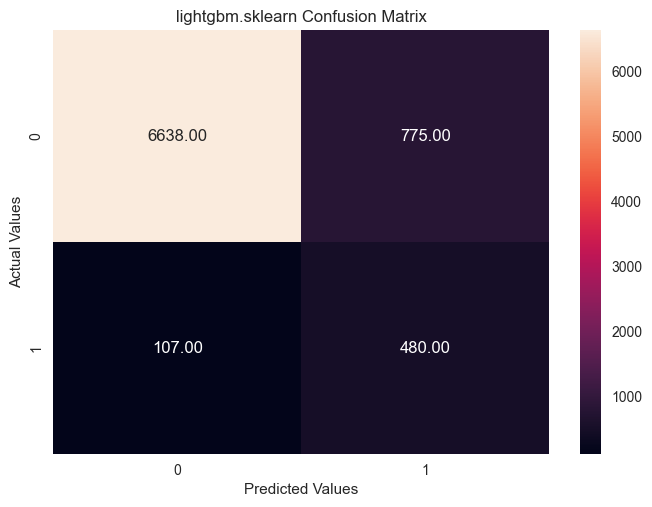

In [79]:

lgb_tuned = LGBMClassifier(max_depth=8,
                           num_leaves=59,
                           min_data_in_leaf=194,
                           num_iterations=10,
                           class_weight={0:class_weights[14], 1:1-class_weights[14]},
                           random_state=seed,
                           force_row_wise=True,
                           verbose=-1
                           )

lgb_tuned.fit(X_train_resampled_tomek, y_train_resampled_tomek)
preds = lgb_tuned.predict(X_test)
print(classification_report(y_test, preds))
conf_matrix = confusion_matrix(y_test, preds)
sns.heatmap(data=conf_matrix, annot=True, fmt='.2f')
plt.title(f'{lgb_tuned.__module__} Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In the end, not JUST looking at precision score was optimal for this model. Looking for a model that ultimately classified as many true negatives as possible, had a fairly decent precision score and had a good recall score along with a good f1 macro score was the model to look for.

In our case the tuned LGBMClassifier reduced call time by roughly 330 hours by identifying over 6600 customers that are NOT going to subscribe to the term deposit product while only losing 107 customers.

In [98]:
duration_of_calls_in_hours = round(X['duration_in_minutes'].sum()/60, 2)
print(f"The total amount of call time during the entirety of the campaign:\n{duration_of_calls_in_hours} hours.\n")

hours_saved = (conf_matrix[0][0]*X['duration_in_minutes'].median())/60 ## number of true negatives x median minutes, then turned to hours

time_saved_percentage = hours_saved/duration_of_calls_in_hours
print(f"Theoretical percentage of time saved from campaign:\n{time_saved_percentage*100:.2f}%")

The total amount of call time during the entirety of the campaign:
2831.38 hours.

Theoretical percentage of time saved from campaign:
11.40%


### Feature Selection
* Using heirarchical clustering and KMeans clustering this section looks to find features that will be helpful to look at when assessing whether a customer will subscribe to the product or not.
* Since the dataset has multiple features that are not easily represented in a 2-dimensional space t-SNE will be implemented to help with dimensionality reduction.

In [99]:
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

######## set X and y to the X and y variables used by pycaret in cell 67
X = s.X
y = s.y
X['y'] = y
X = X[X['y']==1]
X.drop('y', axis=1, inplace=True)

dummied_X = pd.get_dummies(X)
numeric_cols = [col for col in dummied_X.columns if dummied_X[col].dtype!='category']
dummied_X = dummied_X[numeric_cols].astype(float)
dummied_X.head()

,age,default,balance,housing,loan,day,campaign,duration_in_minutes,job_admin,job_blue-collar,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
39054,25.0,0.0,217.0,1.0,0.0,18.0,1.0,8.400000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36714,39.0,0.0,5073.0,1.0,0.0,12.0,1.0,19.700001,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
33968,35.0,0.0,193.0,1.0,0.0,30.0,1.0,9.416667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6162,30.0,0.0,0.0,1.0,1.0,27.0,1.0,17.516666,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20643,40.0,0.0,4396.0,0.0,0.0,12.0,3.0,7.200000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
normalized_df = pd.DataFrame(normalize(dummied_X), columns=dummied_X.columns)
transposed_df =normalized_df.T
print(f"Shape of dummied dataframe:\n{transposed_df.shape}")

transposed_df.head()

Shape of dummied dataframe:
(41, 2896)


,0,1,2,3,4,5,6,7,8,9,...,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895
age,0.113972,0.007687,0.176172,0.680443,0.009099,0.013511,0.241304,0.009702,0.055198,0.105419,...,0.032956,0.027867,0.000862,0.080063,0.038181,0.017373,0.011997,0.021204,0.023278,0.502885
default,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
balance,0.989275,0.999960,0.971461,0.000000,0.999953,0.999839,0.943278,0.999935,0.998160,0.985123,...,0.999423,0.999337,0.999999,0.995789,0.999208,0.999842,0.999899,0.999672,0.999467,-0.811674
housing,0.004559,0.000197,0.005033,0.022681,0.000000,0.000356,0.007312,0.000000,0.000000,0.003635,...,0.000000,0.000000,0.000022,0.002502,0.000812,0.000000,0.000375,0.000000,0.000000,0.008823
loan,0.000000,0.000000,0.000000,0.022681,0.000000,0.000000,0.007312,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008823


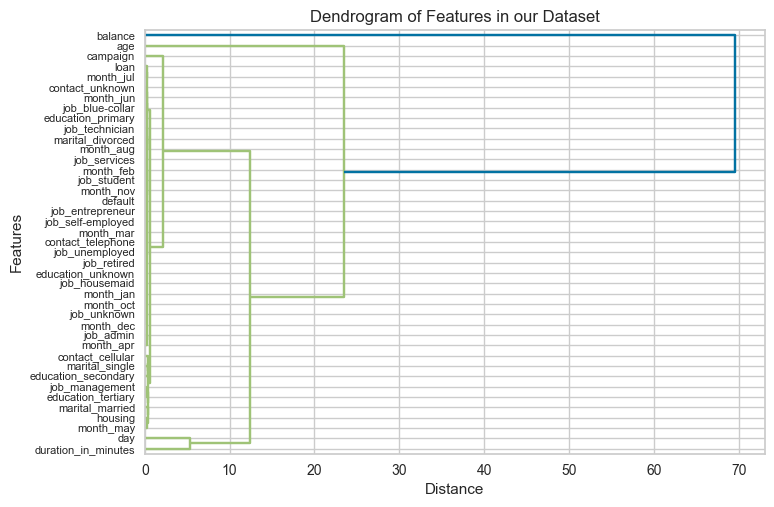

In [101]:
linkage_ = linkage(transposed_df, method='ward', metric='euclidean')
dendrogram(linkage_, labels=numeric_cols, orientation='right', distance_sort='descending', show_leaf_counts=True)
plt.ylabel('Features')
plt.xlabel('Distance')
plt.title('Dendrogram of Features in our Dataset')
plt.show()

In [102]:
from sklearn.cluster import KMeans

#################### for reproducability purposes use seed=4928

seed = 4928
# print(seed)

inertia_list=[]
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, random_state=seed)
    kmeans.fit(normalized_df)
    inertia_list.append(kmeans.inertia_)

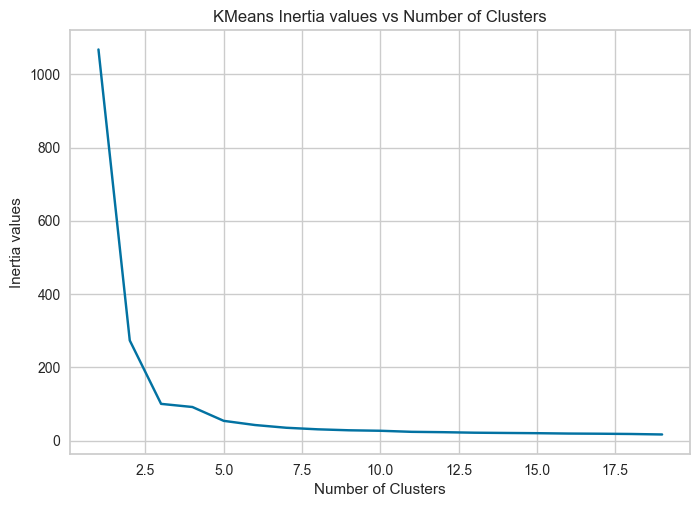

In [103]:
plt.plot(np.arange(1,20), inertia_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia values')
plt.title('KMeans Inertia values vs Number of Clusters')
plt.show()

In [104]:
non_numeric_cols = [col for col in dummied_X.columns if dummied_X[col].dtype == 'category']
X_ = dummied_X.drop(non_numeric_cols, axis=1)

kmeans = KMeans(n_clusters=3, random_state=seed)
kmeans.fit(X_)
X_['kmeans_label'] = kmeans.labels_
X['kmeans_label'] = kmeans.labels_

kmeans.fit(normalized_df)
normalized_df['kmeans_label'] = kmeans.labels_
print('Shape of normalized dataframe: ', normalized_df.shape)
normalized_df.head()

Shape of normalized dataframe:  (2896, 42)


,age,default,balance,housing,loan,day,campaign,duration_in_minutes,job_admin,job_blue-collar,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,kmeans_label
0,0.113972,0.0,0.989275,0.004559,0.000000,0.082060,0.004559,0.038295,0.0,0.004559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004559,0.0,0.0,0
1,0.007687,0.0,0.999960,0.000197,0.000000,0.002365,0.000197,0.003883,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000197,0.0,0.0,0
2,0.176172,0.0,0.971461,0.005033,0.000000,0.151004,0.005033,0.047399,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
3,0.680443,0.0,0.000000,0.022681,0.022681,0.612399,0.022681,0.397303,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.022681,0.0,0.0,2
4,0.009099,0.0,0.999953,0.000000,0.000000,0.002730,0.000682,0.001638,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0


In [105]:
X['kmeans_label'].value_counts()

kmeans_label
0    2474
1     397
2      25
Name: count, dtype: int64

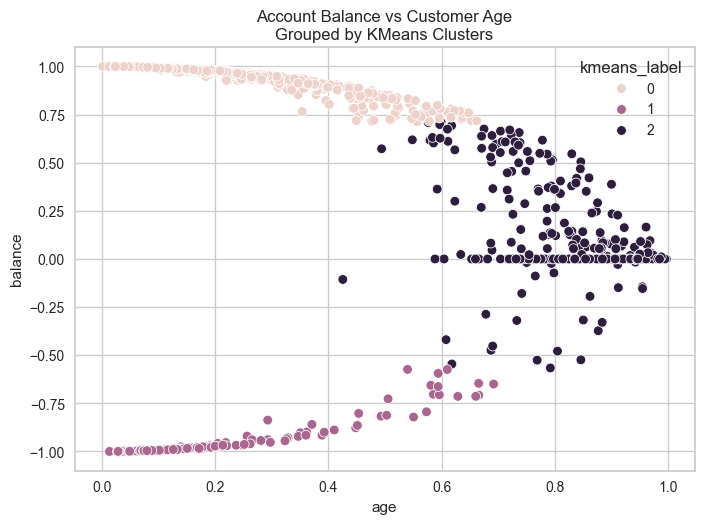

In [108]:
sns.scatterplot(data=normalized_df, x='age', y='balance', hue='kmeans_label')
plt.title('Account Balance vs Customer Age\n\
Grouped by KMeans Clusters')

plt.show()

In [111]:
for i in range(0, len(X['kmeans_label'].unique())):    
    job = X[X['kmeans_label']==i]['job'].value_counts().index[0]
    job_count = round((X[X['kmeans_label']==i]['job'].value_counts()[0]/X[X['kmeans_label']==i]['job'].value_counts().sum()), 3)*100
    education = X[X['kmeans_label']==i]['education'].value_counts().index[0]
    marital = X[X['kmeans_label']==i]['marital'].value_counts().index[0]
    age = X[X['kmeans_label']==i]['age'].median()
    balance = X[X['kmeans_label']==i]['balance'].median()
    print(f"Group {i} has a median age of {age} and a median balance of €{balance}.\n\
    \tThey predominantly have {education} education, have jobs as {job} that make up {job_count}% of their group,\n\
    \tand are {marital}.")

Group 0 has a median age of 37.0 and a median balance of €431.5.
    	They predominantly have secondary education, have jobs as management that make up 22.1% of their group,
    	and are married.
Group 1 has a median age of 39.0 and a median balance of €5024.0.
    	They predominantly have tertiary education, have jobs as management that make up 31.0% of their group,
    	and are married.
Group 2 has a median age of 39.0 and a median balance of €19268.0.
    	They predominantly have tertiary education, have jobs as technician that make up 32.0% of their group,
    	and are single.


In [114]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
# from umap.umap_ import UMAP

pca=PCA(random_state=seed)
tsne=TSNE(random_state=seed, perplexity=50, n_components=3)
# umap_=UMAP(random_state=seed)

pca.fit_transform(normalized_df)
tsne_fit = tsne.fit_transform(X_)
# umap_fit = umap_.fit_transform(dummy_new_X)

In [115]:
pca.explained_variance_ratio_.cumsum()

array([0.84408979, 0.97044631, 0.98868148, 0.99518675, 0.99918009,
       0.99966272, 0.9997132 , 0.99975628, 0.99979211, 0.99982127,
       0.99984128, 0.99985832, 0.99987439, 0.9998889 , 0.99990105,
       0.99991241, 0.99992265, 0.99993235, 0.99994044, 0.99994812,
       0.99995526, 0.99996168, 0.99996685, 0.99997142, 0.99997551,
       0.99997918, 0.99998246, 0.9999857 , 0.99998875, 0.99999133,
       0.99999367, 0.99999532, 0.99999673, 0.99999791, 0.99999879,
       0.99999949, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

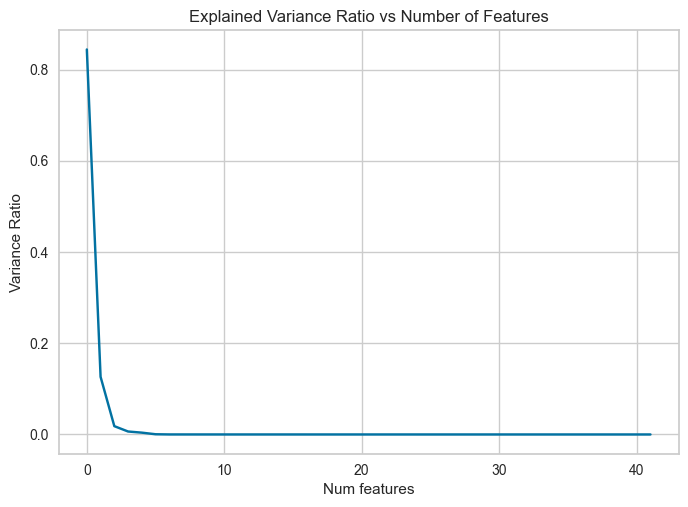

In [116]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Num features')
plt.ylabel('Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Features')
plt.show()

What this is saying is, like the dendrogram above, we can use roughly 3 features to show which customer is likely to subscribe to our term deposit product.

In the dendrogram, it was balance, age, and then everything else was fairly comparable. This shows the same thing with 2 definitely being the least we can use and 3 being the most features we could use.

In [117]:
pca = PCA(n_components=3, random_state=seed)
pca_fit = pca.fit_transform(normalized_df)
normalized_df['pca_x'] = pca_fit[:, 0]
normalized_df['pca_y'] = pca_fit[:, 1]
# normalized_df[['pca_x', 'pca_y']].head()

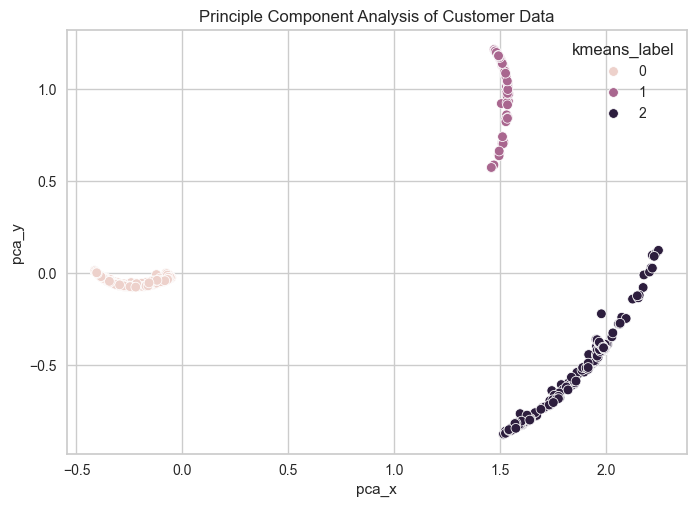

In [118]:
sns.scatterplot(data=normalized_df, x='pca_x', y='pca_y', hue='kmeans_label')
plt.title('Principle Component Analysis of Customer Data')
plt.show()

In [119]:
X['tsne_x'] = tsne_fit[:, 0]
X['tsne_y'] = tsne_fit[:, 1]
X['tsne_z'] = tsne_fit[:, 2]
# X[['tsne_x', 'tsne_y', 'tsne_z']].head()

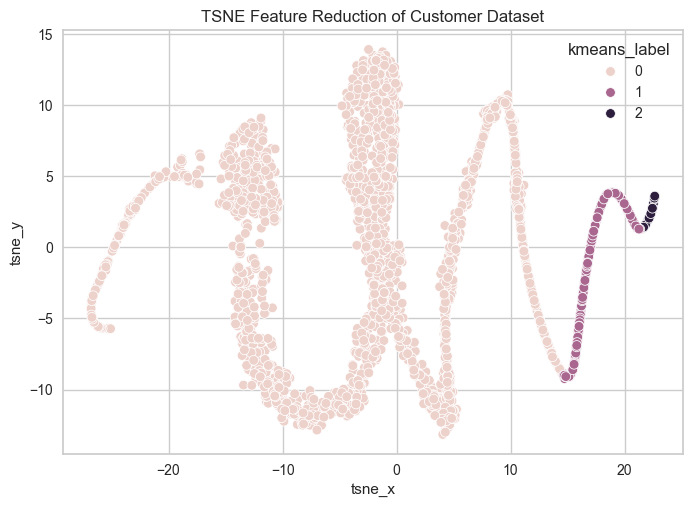

In [121]:
sns.scatterplot(data=X, x='tsne_x', y='tsne_y', hue='kmeans_label')
plt.title('TSNE Feature Reduction of Customer Dataset')
plt.show()

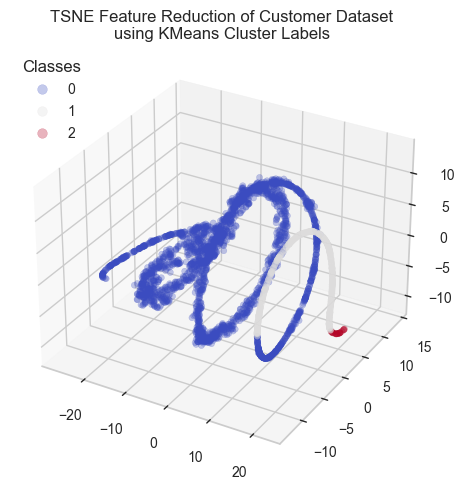

In [124]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X['tsne_x'],
                     X['tsne_y'],
                     X['tsne_z'],
                     c=X['kmeans_label'],
                     alpha=.3,
                     cmap='coolwarm'
                     )
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")

plt.title('TSNE Feature Reduction of Customer Dataset\n\
using KMeans Cluster Labels')
plt.show()

In [125]:
##### these last three cells are for dashboard purposes

import os
from pathlib import Path

X['y'] = target_variable
X['index'] = X.index

directory_path = Path('Data')
file_path = 'term_subscribers_labels.csv'
full_path = os.path.join(directory_path, file_path)

X.to_csv(full_path)

In [126]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,duration_in_minutes,kmeans_label,tsne_x,tsne_y,tsne_z,y,index
39054,25,blue-collar,single,secondary,0,217,1,0,cellular,18,may,1,8.400000,0,-2.097405,-4.573521,4.079176,1,39054
36714,39,management,single,tertiary,0,5073,1,0,cellular,12,may,1,19.700001,1,17.226398,0.938908,7.858505,1,36714
33968,35,management,married,tertiary,0,193,1,0,cellular,30,apr,1,9.416667,0,-2.812898,-7.140218,3.730691,1,33968
6162,30,entrepreneur,single,primary,0,0,1,1,unknown,27,may,1,17.516666,0,-12.790550,2.667642,-3.689070,1,6162
20643,40,management,married,secondary,0,4396,0,0,cellular,12,aug,3,7.200000,1,16.280703,-3.660581,8.457008,1,20643


In [127]:
# df = pd.read_csv('Data/model-ready-term-deposit-marketing-2020.csv')
# df['index'] = df.index
# df.head()
# df.to_csv('Data/model-ready-term-deposit-marketing-2020.csv')

## Conclusion

* The first section's SGDClassifier obtained ~90% recall score for the positive class equating to roughly 130 hours of saved call time.
* The second section - looking at a mix of recall, precision, true negatives, and f1 macro - saw a LGBMClassifier model obtain a decent precsion score, fairly good recall score, fairly decent f1 macro score and over 6500 true negatives equating to over 330 hours of call time saved.
* Finally, the last section provided a look at the segment of clients that should be prioritized as well as features that make customers subscribe to the product using clustering and dimensionality reduction techniques.
* The main insight from this section was that the KMeans algorithm found 3 clusters that when compared to the categorical features in our original dataset, such as job, education, and marital status, clusters 1 and 2 (if looking at the 3D plot above these are the white and red colors) were found to have tertiary education while the other cluster (blue cluster) had secondary.
* The main segment of customers to prioritize are those customers that have tertiary or secondary education levels and who have balances above €5,000. The feature that will deserve the greatest attention will be the customers' balance.